# Key indicators vs SHAP

Can we pick out anything that could be useful or predictive

In [1]:
import os
import pandas as pd
import numpy as np  # for NaN

In [9]:
from scipy.stats import pearsonr

In [10]:
import matplotlib.pyplot as plt

### Import data

In [2]:
dir_files = '../data/organisational_audit/processed'
file_excel = 'processed_2019_portfolio_key_indicators_summary_numeric_shap.csv'

In [3]:
df = pd.read_csv(os.path.join(dir_files, file_excel))

In [7]:
df.columns

Index(['Hospital names', 'acute_unit', 'bed1', 'bed3', 'ki_total', 'ki1',
       'ki1_nurses6_wte', 'ki1_nurses7_wte', 'ki2', 'ki2_psych_wte', 'ki3',
       'ki3_strokenurse_bed1_saturdays', 'ki3_strokenurse_bed1_saturdays10pm',
       'ki3_strokenurse_bed1_sundays', 'ki3_strokenurse_bed1_sundays10pm',
       'ki3_strokenurse_bed1_weekdays10pm', 'ki3_strokenurse_bed3_saturdays',
       'ki3_strokenurse_bed3_saturdays10pm', 'ki3_strokenurse_bed3_sundays',
       'ki3_strokenurse_bed3_sundays10pm', 'ki3_strokenurse_bed3_weekdays10pm',
       'ki3_strokenurse_outofhours', 'ki4',
       'ki4_minimum_nurse_bed1_saturdays10am',
       'ki4_minimum_nurse_bed1_sundays10am',
       'ki4_minimum_nurse_bed3_saturdays10am',
       'ki4_minimum_nurse_bed3_sundays10am', 'ki5',
       'ki5_occupationaltherapy_7days', 'ki5_physiotherapy_7days',
       'ki5_speechlanguagetherapy_7days', 'ki6', 'ki6_prealert_consultant',
       'ki6_prealert_fastpositive_sometimes', 'ki6_prealert_fastpositive_yes',
    

## Simple correlation check

In [6]:
cols_ki = [f'ki{i}' for i in range(1, 11)]

In [13]:
cols_ki_names = [
    'Enough nurses',
    'Psychologist',
    'Out-of-hours stroke specialist nurse',
    'Enough nurses at weekends',
    'Therapy availability',
    'Pre-alert',
    'Early supported discharge',
    'Patient & carer survey',
    'MRI for TIA patients',
    'Management'
]

In [11]:
shap_ki_coeffs = []

for col in cols_ki:
    p = pearsonr(df[col], df['shap_mean'])
    shap_ki_coeffs.append(p.statistic)

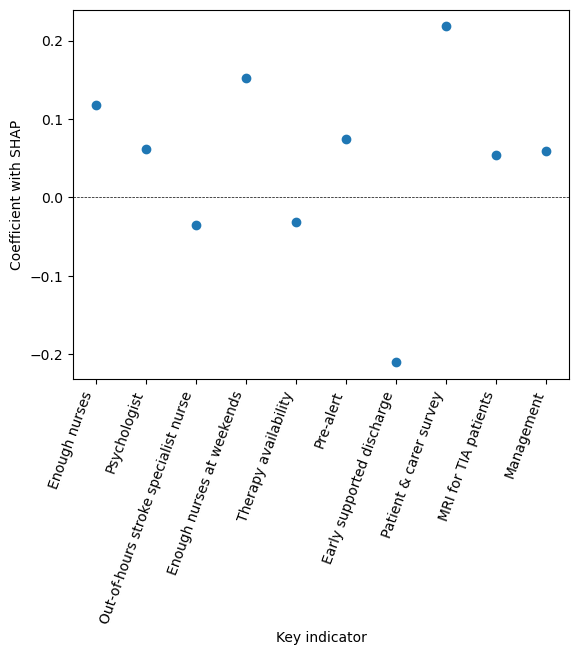

In [19]:
fig, ax = plt.subplots()

ax.scatter(cols_ki, shap_ki_coeffs)

ax.axhline(0.0, linewidth=0.5, color='k', linestyle='--')

ax.set_xticks(np.arange(len(cols_ki)))
ax.set_xticklabels(cols_ki_names, rotation=70, ha='right')

ax.set_xlabel('Key indicator')
ax.set_ylabel('Coefficient with SHAP')

plt.show()

## Total KIs met vs SHAP

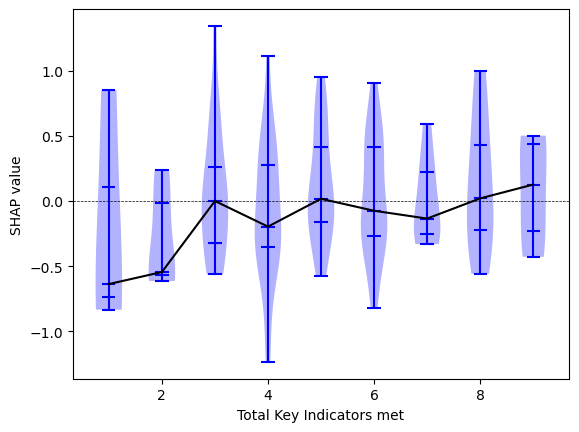

In [60]:
total_kis = df['ki_total'].values
shap_vals = df['shap_mean'].values

meds_by_total_ki = []

fig, ax = plt.subplots()

for total_ki in sorted(list(set(total_kis))):
    inds = np.where(total_kis == total_ki)[0]
    med = np.median(shap_vals[inds])
    meds_by_total_ki.append(med)

    vio =  ax.violinplot(shap_vals[inds], positions=[total_ki], quantiles=[0.25, 0.5, 0.75])
    
    for pc in vio['bodies']:
        pc.set_facecolor('b')

    # Change line colours:
    for partname in ('cbars', 'cmins', 'cmaxes', 'cquantiles'):
        vp = vio[partname]
        vp.set_edgecolor('b')

ax.plot(sorted(list(set(total_kis))), meds_by_total_ki, color='k')
ax.axhline(0.0, color='k', linestyle='--', linewidth=0.5)

ax.set_xlabel('Total Key Indicators met')
ax.set_ylabel('SHAP value')
plt.show()

## Violins by ki yes/no

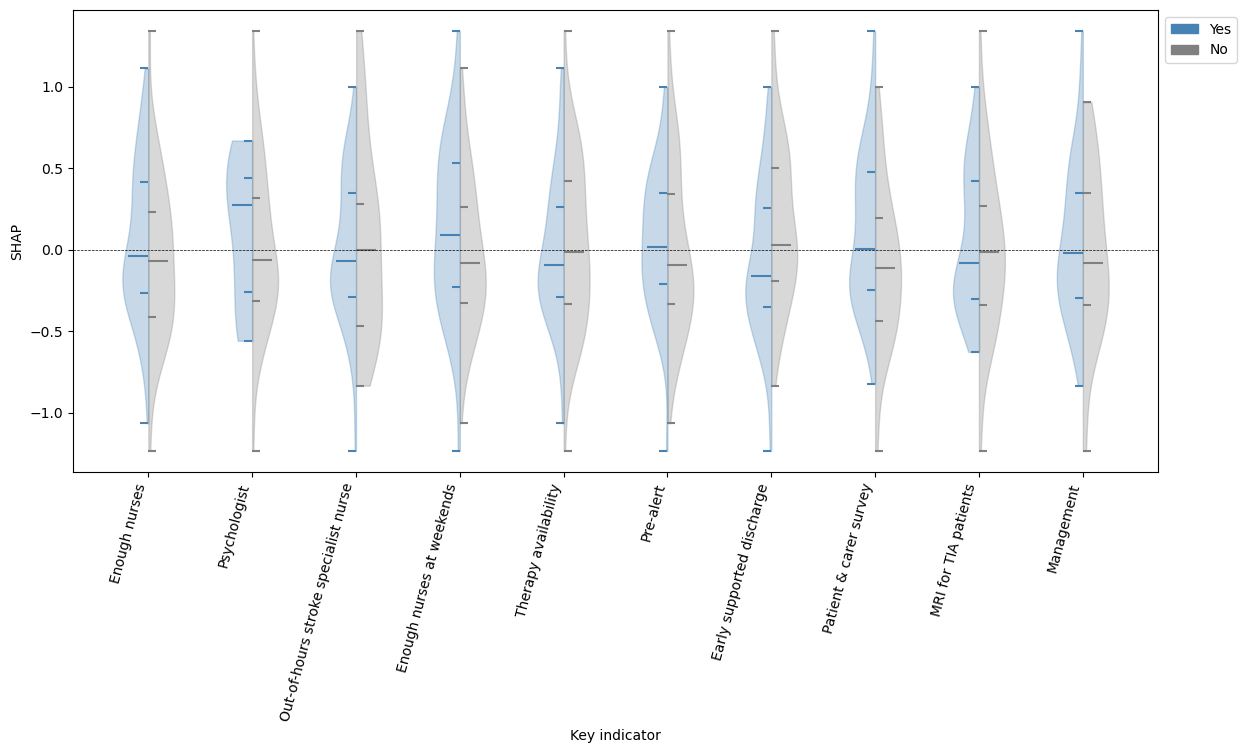

In [84]:
shap_vals = df['shap_mean'].values

colour_yes = 'SteelBlue'
colour_no = 'grey'

fig, ax = plt.subplots(figsize=(14, 6))

for c, col in enumerate(cols_ki):
    ki_vals = df[col].values

    inds_yes = np.where(ki_vals == 1)[0]
    shap_yes = shap_vals[inds_yes]
    
    inds_no = np.where(ki_vals == 0)[0]
    shap_no = shap_vals[inds_no]


    vio_yes = ax.violinplot(shap_yes, positions=[c], showextrema=False)
    vio_no = ax.violinplot(shap_no, positions=[c], showextrema=False)

    # Turn these into half violins by following this: https://stackoverflow.com/a/29781988
    for b in vio_yes['bodies']:
        # get the center
        m = np.mean(b.get_paths()[0].vertices[:, 0])
        # modify the paths to not go further right than the center
        b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], -np.inf, m)
        b.set_color(colour_yes)
    
    for b in vio_no['bodies']:
        # get the center
        m = np.mean(b.get_paths()[0].vertices[:, 0])
        # modify the paths to not go further left than the center
        b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
        b.set_color(colour_no)

    # Make whiskers only stick out on one half:
    yn_data = [shap_yes, shap_no]
    yn_markers = [0, 1]  # as int, not string, are TICKLEFT and TICKRIGHT.
    yn_colours = [colour_yes, colour_no]

    for i in [0, 1]:
        data = yn_data[i]

        marks = np.percentile(data, [0, 25, 75, 100])        
        ax.scatter([c]*len(marks), marks, marker=yn_markers[i], color=yn_colours[i])

        # Draw the median separately so it can stand out:
        marks = np.percentile(data, [50])        
        ax.scatter([c]*len(marks), marks, marker=yn_markers[i], color=yn_colours[i], s=200)

ax.axhline(0.0, color='k', linestyle='--', linewidth=0.5)
# ax.set_ylim(-1.6, 1.6)
# ax.set_ylim(0, 25)
ax.set_xlabel('Key indicator')
ax.set_ylabel('SHAP')
ax.set_xticks(np.arange(len(cols_ki)))
ax.set_xticklabels(cols_ki_names, rotation=75, ha='right')

import matplotlib.patches as mpatches
patch_yes = mpatches.Patch(color=colour_yes, label='Yes')
patch_no = mpatches.Patch(color=colour_no, label='No')

ax.legend(
    handles=[patch_yes, patch_no],
    bbox_to_anchor=[1.0, 1.0], loc='upper left'  # outside main axis
)
plt.show()

^ limitation - the two halves of the violin have the same width which makes it look like they both contain the same number of data points. It's not the case though.

Possible fixes
- set required width by running histograms first to get an idea of the tallest bin / widest point
- create violin normally and later scale down width so that area matches number of points.

## Histograms by ki yes/no

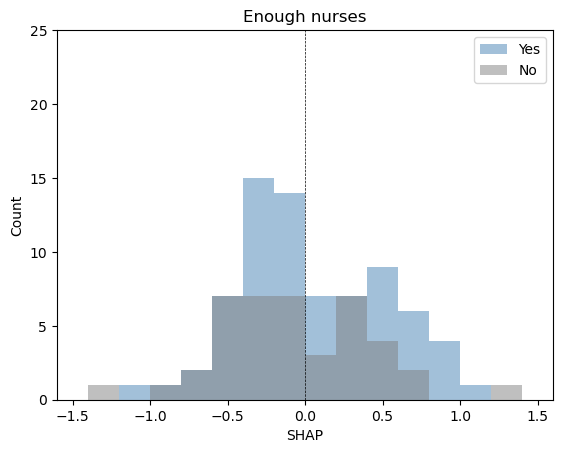

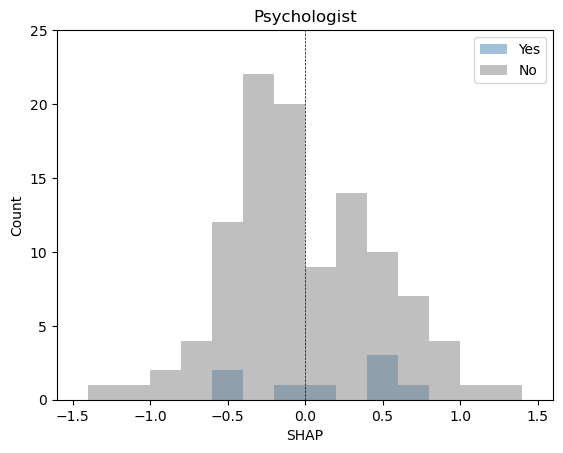

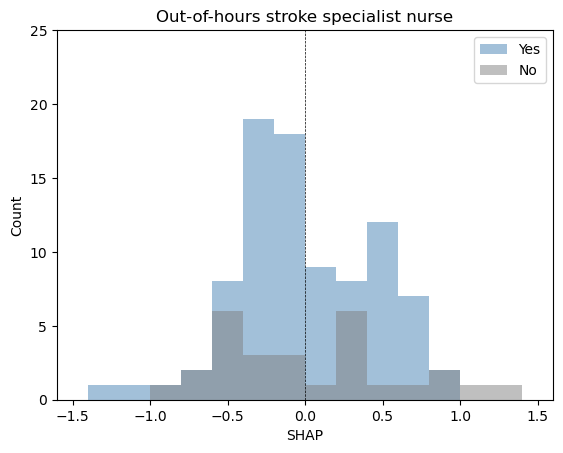

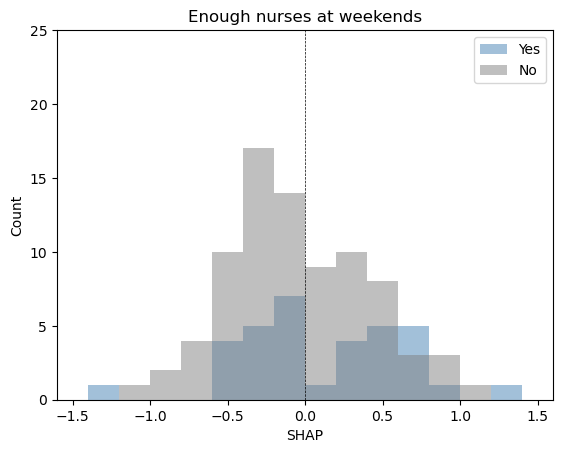

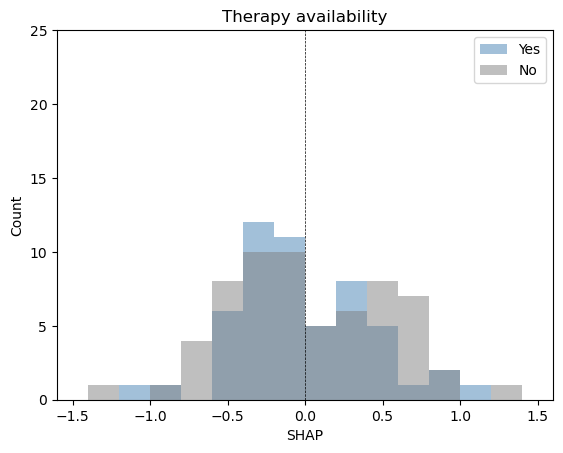

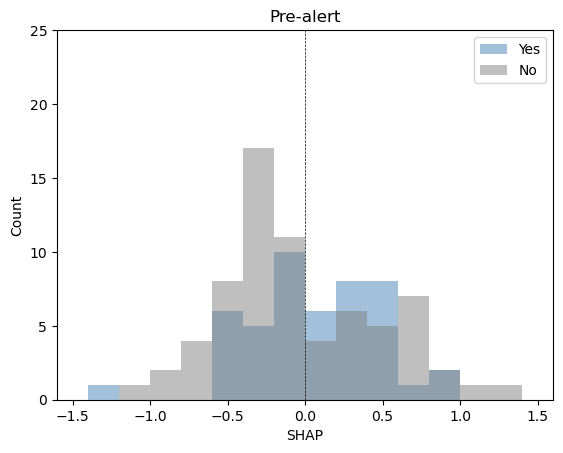

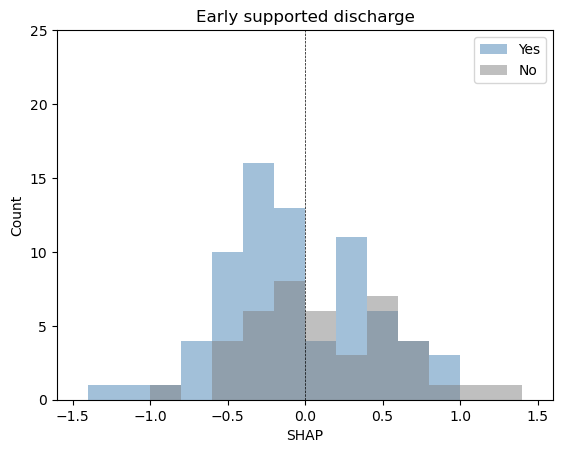

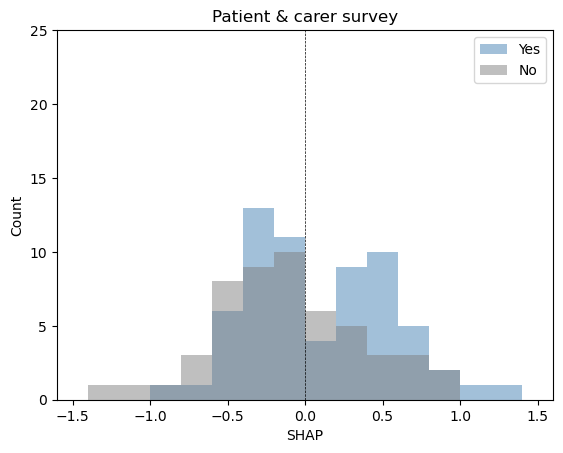

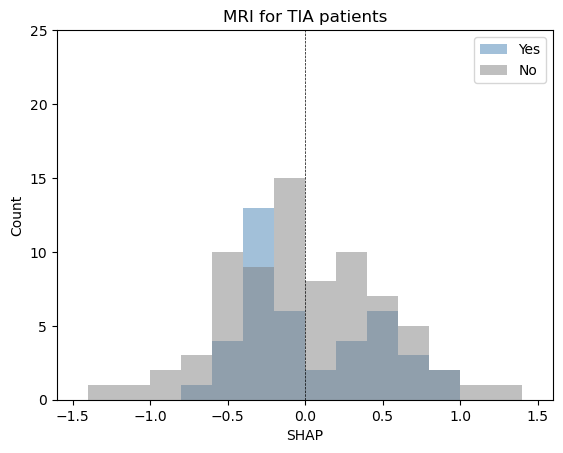

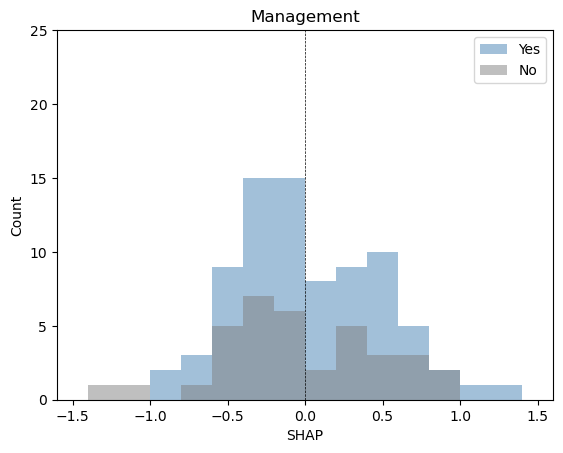

In [39]:
shap_vals = df['shap_mean'].values

for c, col in enumerate(cols_ki):
    ki_vals = df[col].values

    inds_yes = np.where(ki_vals == 1)[0]
    shap_yes = shap_vals[inds_yes]
    
    inds_no = np.where(ki_vals == 0)[0]
    shap_no = shap_vals[inds_no]

    fig, ax = plt.subplots()

    bins = np.arange(-1.6, 1.61, 0.2)
    ax.hist(shap_yes, bins=bins, color='SteelBlue', label='Yes', alpha=0.5)#, edgecolor='b', histtype='step')
    ax.hist(shap_no, bins=bins, color='grey', label='No', alpha=0.5)#, edgecolor='k', histtype='step')

    ax.axvline(0.0, color='k', linestyle='--', linewidth=0.5)
    ax.set_xlim(-1.6, 1.6)
    ax.set_ylim(0, 25)
    ax.set_xlabel('SHAP')
    ax.set_ylabel('Count')
    ax.set_title(cols_ki_names[c])
    ax.legend()
    plt.show()

## Linear regression

In [85]:
from sklearn.linear_model import LinearRegression

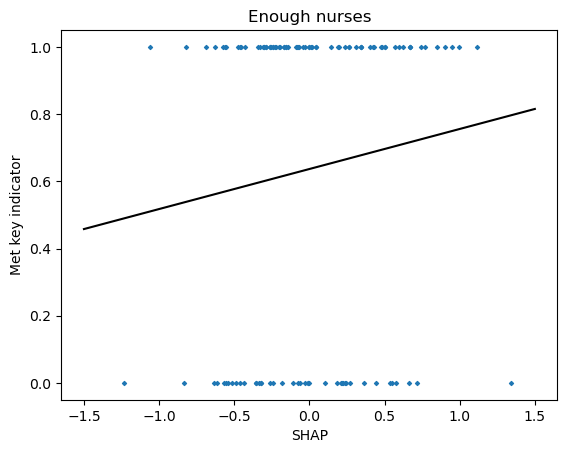

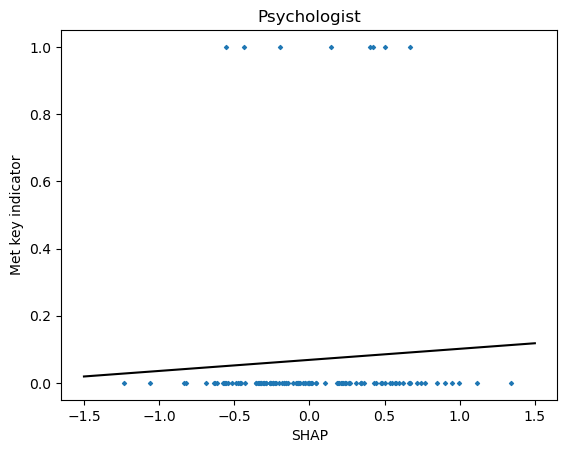

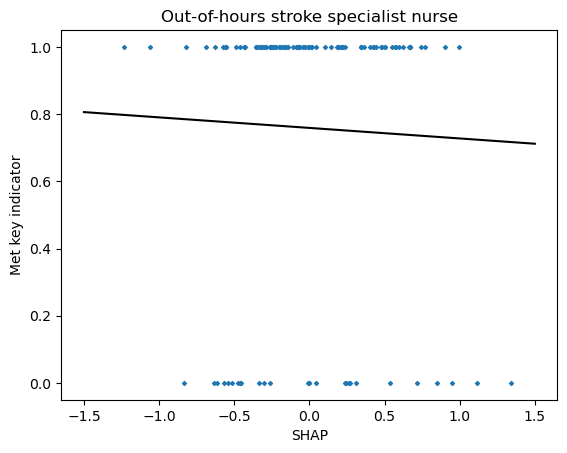

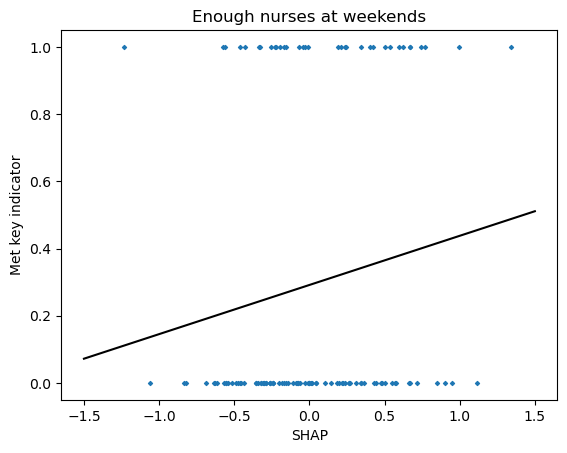

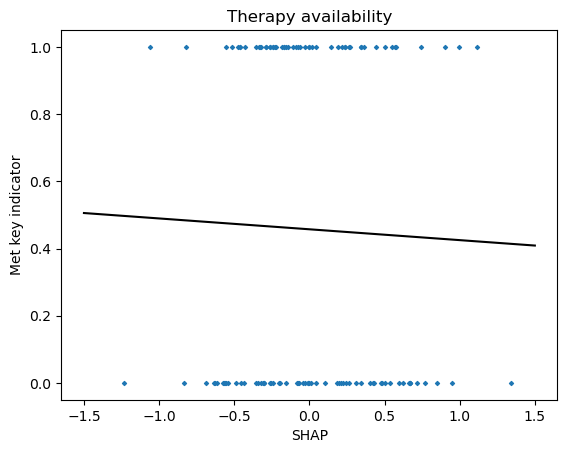

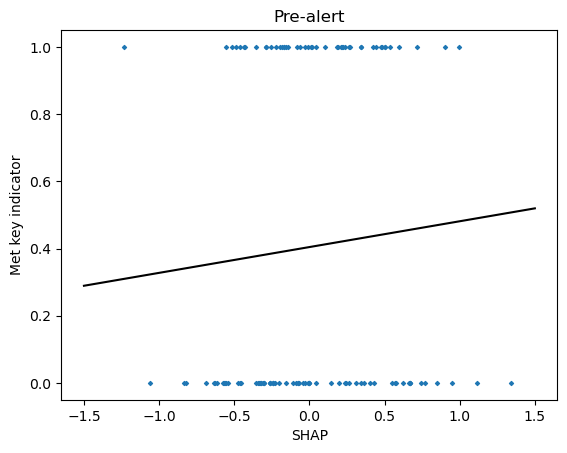

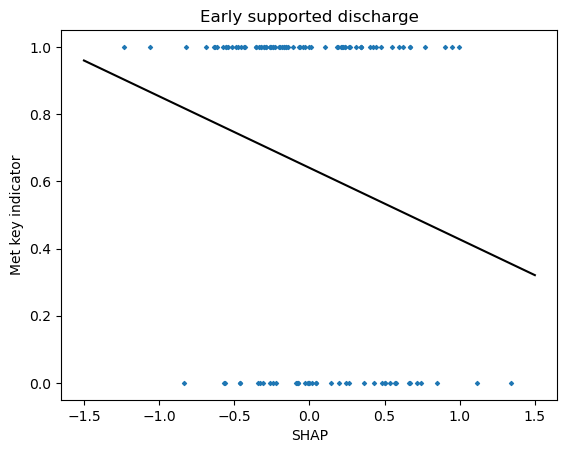

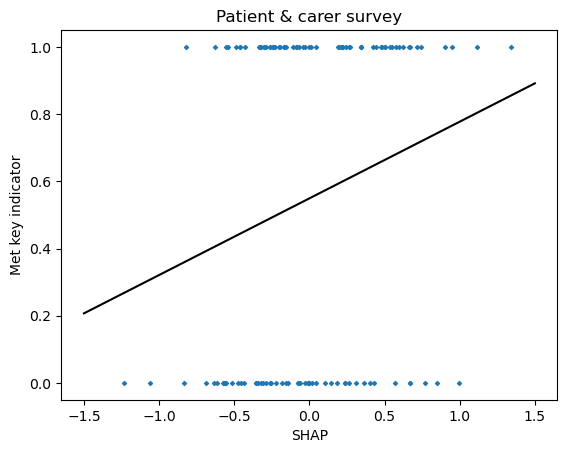

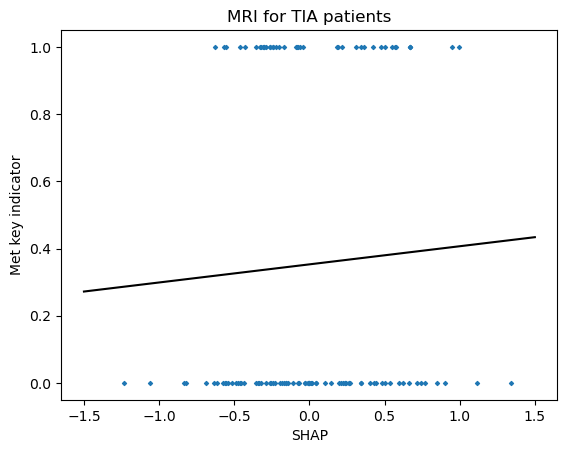

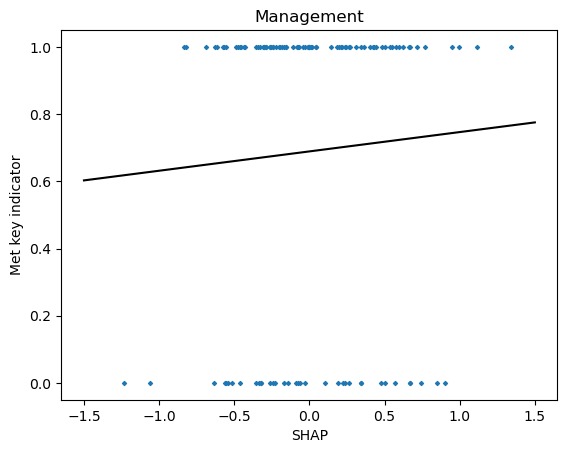

In [94]:
shap_vals = df['shap_mean'].values

x_values = np.linspace(-1.5, 1.5, 100).reshape(-1, 1)

for c, col in enumerate(cols_ki):
    ki_vals = df[col].values

    x = np.array(shap_vals).reshape(-1, 1)
    y = np.array(ki_vals).reshape(-1, 1)

    # Create linear regression object
    regr = LinearRegression()
    # Train the model using the training sets
    regr.fit(x, y)
    # Make predictions using the testing set
    pred = regr.predict(x_values)

    fig, ax = plt.subplots()
    ax.scatter(shap_vals, ki_vals, s=4, marker='D')
    ax.plot(x_values, pred, color='k')

    ax.set_xlabel('SHAP')
    ax.set_ylabel('Met key indicator')
    ax.set_title(cols_ki_names[c])
    plt.show()

## Logistic regression

In [95]:
from sklearn.linear_model import LogisticRegression
from scipy.special import expit

/home/anna/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


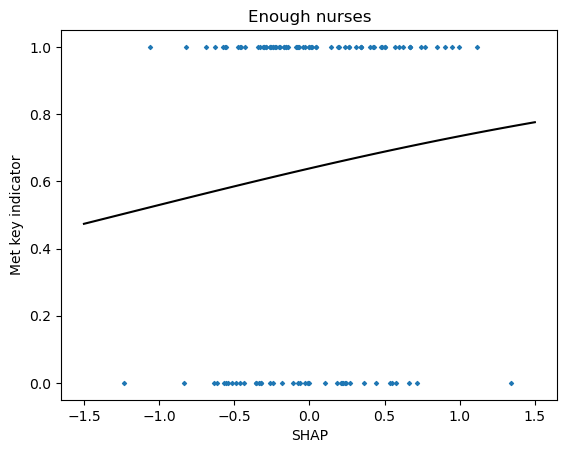

/home/anna/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


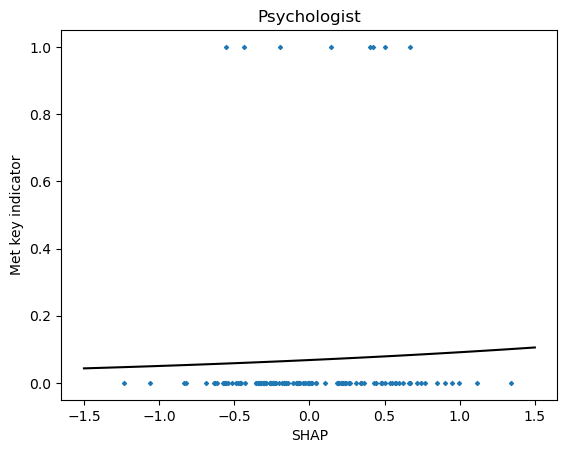

/home/anna/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


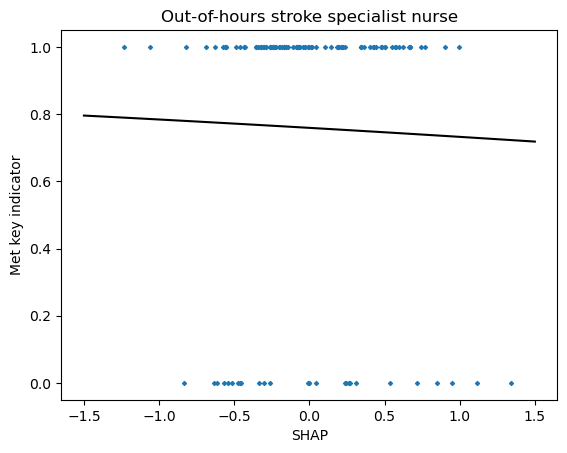

/home/anna/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


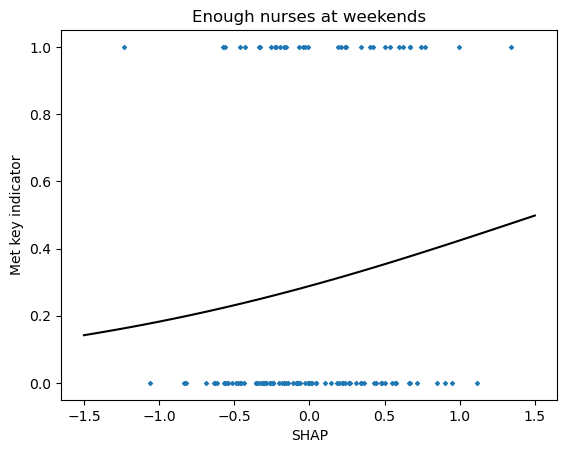

/home/anna/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


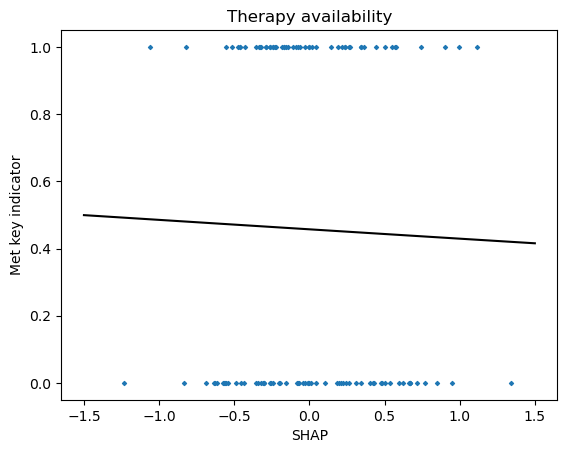

/home/anna/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


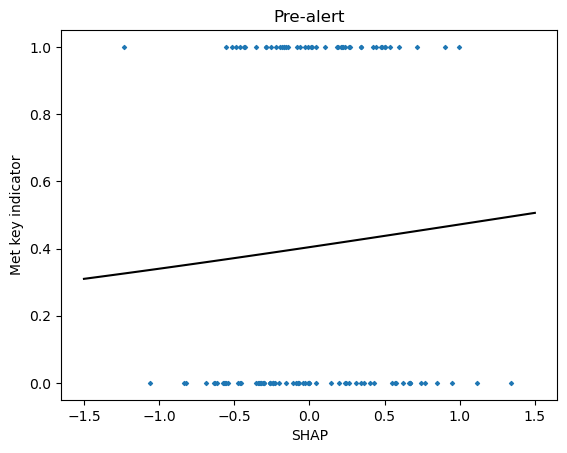

/home/anna/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


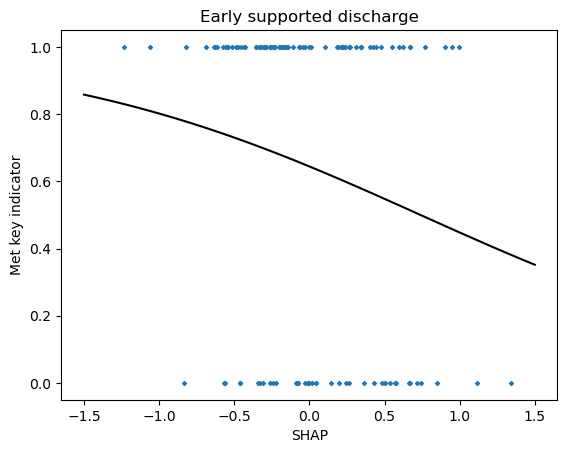

/home/anna/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


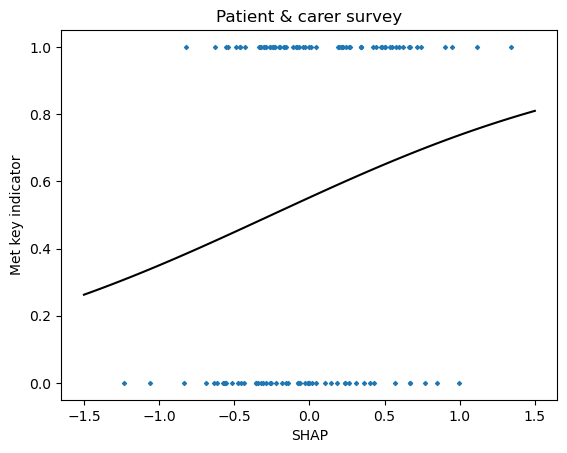

/home/anna/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


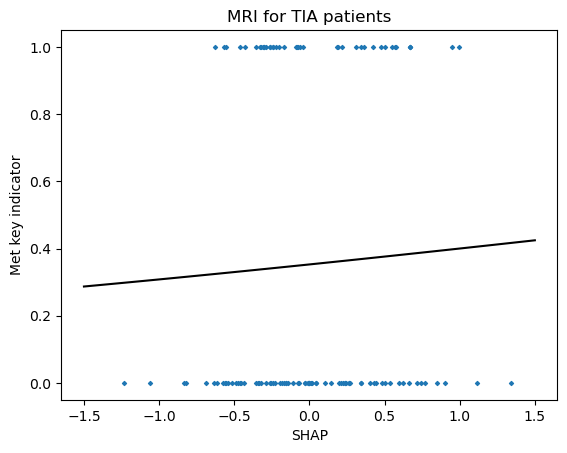

/home/anna/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


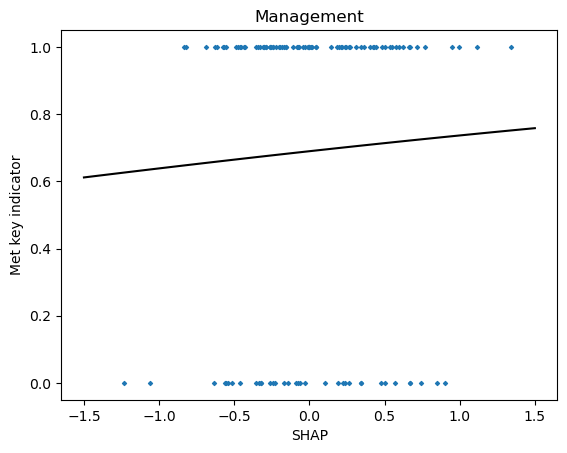

In [99]:
shap_vals = df['shap_mean'].values

x_values = np.linspace(-1.5, 1.5, 100).reshape(-1, 1)

for c, col in enumerate(cols_ki):
    ki_vals = df[col].values

    x = np.array(shap_vals).reshape(-1, 1)
    y = np.array(ki_vals).reshape(-1, 1)

    # Create logistic regression object
    clf = LogisticRegression()
    # Train the model using the training sets
    clf.fit(x, y)
    
    pred = expit(x_values * clf.coef_ + clf.intercept_).ravel()

    fig, ax = plt.subplots()
    ax.scatter(shap_vals, ki_vals, s=4, marker='D')
    ax.plot(x_values, pred, color='k')

    ax.set_xlabel('SHAP')
    ax.set_ylabel('Met key indicator')
    ax.set_title(cols_ki_names[c])
    plt.show()